# 1. IMPORT AND CLEAN JSONS

First, import and clean the meeting data. 

In [1]:
import json
import re

# Helper function to clean text
def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace and line breaks
    return text

# Function to clean a meeting entry
def clean_meeting(meeting):
    if isinstance(meeting, dict):
        return {key: clean_text(value) for key, value in meeting.items()}
    elif isinstance(meeting, str):
        return clean_text(meeting)
    else:
        return meeting

# Function to clean the entire dataset
def clean_data(data, term):
    for entry in data:
        entry["name"] = clean_text(entry.get("name", ""))
        entry["group"] = clean_text(entry.get("group", ""))
        entry["origin_country"] = clean_text(entry.get("origin_country", ""))
        entry["national_party"] = clean_text(entry.get("national_party", ""))
        entry["assistants"] = entry.get("assistants", {})

        # Clean meetings if it exists and is a dictionary
        meetings = entry.get("meetings", {})
        if isinstance(meetings, dict):
            for meeting_id, meeting in meetings.items():
                meetings[meeting_id] = clean_meeting(meeting)
        elif isinstance(meetings, str):
            # If meetings is a string like "No meetings for this MEP", just clean it
            entry["meetings"] = clean_text(meetings)

        # Add the term information
        entry["term"] = term

    return data

# File paths
path_9th_term = r"C:\Users\Emilia\Documents\Uni Helsinki\Year Three\AMO Freelance\transparency register\9 term\raw data\9term_meetings_ALL_INFO.json"
path_10th_term = r"C:\Users\Emilia\Documents\Uni Helsinki\Year Three\AMO Freelance\transparency register\10 term\raw data\national party 10-11-2024\mep_meetings_FULL_w_nationalParty.json"

# Load and clean the 9th term data
with open(path_9th_term, 'r', encoding='utf-8') as file:
    data_9th_term = json.load(file)
    cleaned_9th_term = clean_data(data_9th_term, term=9)

# Load and clean the 10th term data
with open(path_10th_term, 'r', encoding='utf-8') as file:
    data_10th_term = json.load(file)
    cleaned_10th_term = clean_data(data_10th_term, term=10)

# Save the cleaned data to new JSON files
with open('cleaned_9th_term.json', 'w', encoding='utf-8') as file:
    json.dump(cleaned_9th_term, file, indent=4, ensure_ascii=False)

with open('cleaned_10th_term.json', 'w', encoding='utf-8') as file:
    json.dump(cleaned_10th_term, file, indent=4, ensure_ascii=False)

print("Data cleaned successfully and saved to 'cleaned_9th_term.json' and 'cleaned_10th_term.json'.")

Data cleaned successfully and saved to 'cleaned_9th_term.json' and 'cleaned_10th_term.json'.


Next, import the transparency registry. 

In [2]:
path_transparency_register = "C:/Users/Emilia/Documents/Uni Helsinki/Year Three/AMO Freelance/transparency register/2024_registered_orgs_grouped.json"

with open(path_transparency_register, 'r', encoding='utf-8') as file:
    transparency_register = json.load(file)

# 2. ANALYSE NAME SIMILARITIES/LANGUAGES USED 

In [3]:
import re
from collections import Counter
from langdetect import detect
from fuzzywuzzy import fuzz, process
from concurrent.futures import ThreadPoolExecutor
import functools

Set up keyword and company lists

In [4]:
company_list = [
    "Tiktok", "Shein", "Temu", "MG Motor", "Volvo Cars", "ZTE Corporation",  
    "Pirelli", "KUKA Robotics", "Huawei Technologies", "Nuctech", "BYD (Build Your Dreams)",  
    "Lenovo Group", "Geely Automobile Holdings", "SAIC Motor Corporation", "NIO Inc.", 
    "Xiaomi Corporation", "Haier Group Corporation", "Hisense Group", "China National Chemical Corporation (ChemChina)",
    "China COSCO Shipping Corporation", "China Three Gorges Corporation", "State Grid Corporation of China", 
    "China General Nuclear Power Group (CGN)", "Tencent Holdings", "Alibaba Group", "JD.com", "Drone DJI", 
    "Ant Group", "DJI Europe B.V.", "Hangzhou Hikvision Digital Technology Co., Ltd.", "Taiwan Semiconductor Manufacturing Company Ltd" # taken from transparency registry
    ]

In [5]:
c_keywords = [
    "China", "Chinese", "Beijing", "Mandarin", "Confucius", # English
    "Китай", "Китайски", "Пекин", "Мандарин", "Конфуций", # Bulgarian
    "Kina", "Kineski", "Peking", "Mandarinski", "Konfucije", # Croatian
    "Čína", "Čínský", "Peking", "Mandarínština", "Konfucius", # Czech
    "Kina", "Kinesisk", "Beijing", "Mandarin", "Konfucius", # Danish
    "China", "Chinees", "Peking", "Mandarijn", "Confucius", # Dutch
    "Hiina", "Hiina keel", "Peking", "Mandariin", "Konfutsius", # Estonian
    "Kiina", "Kiinalainen", "Peking", "Mandariini", "Kungfutse", # Finnish
    "Chine", "Chinois", "Pékin", "Mandarin", "Confucius", # French
    "China", "Chinesisch", "Peking", "Mandarin", "Konfuzius", # German
    "Κίνα", "Κινέζικα", "Πεκίνο", "Μανδαρινικά", "Κομφούκιος", # Greek
    "Kína", "Kínai", "Peking", "Mandarin", "Konfuciusz", # Hungarian
    "An tSín", "Sínis", "Béising", "Mandairínis", "Confucius", # Irish
    "Cina", "Cinese", "Pechino", "Mandarino", "Confucio", # Italian
    "Ķīna", "Ķīniešu", "Pekina", "Mandarīnu", "Konfūcijs", # Latvian
    "Kinija", "Kinų", "Pekinas", "Mandarinų", "Konfucijus", # Lithuanian
    "Ċina", "Ċiniż", "Beijing", "Mandarin", "Konfuzju", # Maltese
    "Chiny", "Chiński", "Pekin", "Mandaryński", "Konfucjusz", # Polish
    "China", "Chinês", "Pequim", "Mandarim", "Confúcio", # Portuguese
    "China", "Chinez", "Beijing", "Mandarină", "Confucius", # Romanian
    "Čína", "Čínsky", "Peking", "Mandarínčina", "Konfucius", # Slovak
    "Kitajska", "Kitajski", "Peking", "Mandarinščina", "Konfucij", # Slovenian
    "China", "Chino", "Pekín", "Mandarín", "Confucio", # Spanish
    "Kina", "Kinesiska", "Peking", "Mandarin", "Konfucius" # Swedish
]

In [6]:
hk_keywords = [
    "Hong Kong", # English
    "Hong Kong", # Dutch
    "Хонконг",   # Bulgarian
    "Hong Kong", # Croatian
    "Hong Kong", # Czech
    "Hong Kong", # Danish
    "Hong Kong", # Estonian
    "Hong Kong", # Finnish
    "Hong Kong", # French
    "Hong Kong", # German
    "Χονγκ Κονγκ", # Greek 
    "Hong Kong", # Hungarian
    "Hong Kong", # Irish
    "Hong Kong", # Italian
    "Hong Kong", # Latvian
    "Hong Kong", # Lithuanian
    "Hong Kong", # Maltese
    "Hong Kong", # Polish
    "Hong Kong", # Portuguese
    "Hong Kong", # Romanian
    "Hong Kong", # Slovak
    "Hong Kong", # Slovenian
    "Hong Kong", # Spanish
    "Hong Kong", # Swedish¨
]


In [7]:
t_keywords = [
    "Taiwan", "Taipei", # English
    "Тайван", "Тайпе", # Bulgarian
    "Tajvan", "Taipei", # Croatian
    "Tchaj-wan", "Tchaj-pej", # Czech
    "Taiwan", "Taipei", # Danish
    "Taiwan", "Taipei", # Dutch
    "Taiwan", "Taipei", # Estonian
    "Taiwan", "Taipei", # Finnish
    "Taïwan", "Taipei", # French
    "Taiwan", "Taipeh", # German
    "Ταϊβάν", "Ταϊπέι", # Greek
    "Tajvan", "Tajpej", # Hungarian
    "Taiwan", "Taipei", # Irish
    "Taiwan", "Taipei", # Italian
    "Taivāna", "Taibei", # Latvian
    "Taivanas", "Taipėjus", # Lithuanian
    "Tajwan", "Taipei", # Maltese
    "Tajwan", "Tajpej", # Polish
    "Taiwan", "Taipé", # Portuguese
    "Taiwan", "Taipei", # Romanian
    "Taiwan", "Tchaj-pej", # Slovak
    "Tajvan", "Tajpej", # Slovenian
    "Taiwán", "Taipéi", # Spanish
    "Taiwan", "Taipei", # Swedish
]

Define functions that will be used to analyse the meeting data

## 2.1 first try code 11-11-2024

In [ ]:
# Helper function to clean text
def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace and line breaks
    return text

# Helper function to detect language (use a cache to improve speed for repeated texts)
language_cache = {}

def detect_language(text):
    if text in language_cache:
        return language_cache[text]
    
    try:
        language = detect(text)
        language_cache[text] = language  # Cache the result
        return language
    except Exception:
        return "unknown"

# Helper function to find similar names (with fuzz score threshold)
company_match_cache = {}

def find_similar_names(name, company_list):
    if name in company_match_cache:
        return company_match_cache[name]
    
    matches = process.extract(name, company_list, scorer=fuzz.partial_ratio, limit=1)
    if matches and matches[0][1] > 95:  # Threshold for similarity (adjustable)
        company_match_cache[name] = (matches[0][0], matches[0][1])  # Cache the result
        return matches[0][0], matches[0][1]
    
    company_match_cache[name] = None  # Cache the result for non-matches
    return None

# Function to check if any keyword is present in the text
def contains_keywords(text):
    if not isinstance(text, str):
        return False
    # Use a case-insensitive search for any of the keywords
    pattern = re.compile(r'\b(?:' + '|'.join(re.escape(keyword) for keyword in keywords) + r')\b', re.IGNORECASE)
    return bool(pattern.search(text))

# Function to analyze individual meeting data (this will be used in parallel)
def analyze_meeting(entry, company_list):
    merged_meetings = []  # To store merged meetings with keyword matches
    meetings = entry.get("meetings", {})
    mep_name = entry.get("name", "Unknown MEP")  # Assuming this is where the MEP name is stored

    # If meetings is a string (e.g., "No meetings for this MEP"), skip further processing
    if isinstance(meetings, str):
        return merged_meetings

    # Ensure meetings is a dictionary before iterating
    for meeting_id, meeting in meetings.items():
        # Ensure each meeting is a dictionary
        if isinstance(meeting, dict):
            # Clean and detect language
            reason = clean_text(meeting.get("reason", ""))
            meeting_with = clean_text(meeting.get("meeting_with", ""))
            capacity = clean_text(meeting.get("capacity", ""))
            language = detect_language(reason)
            date = meeting.get("date", "Date not provided")  # Assumed field for date

            # Check if any keywords are present in the reason or meeting_with
            reason_has_keywords = contains_keywords(reason)
            meeting_with_has_keywords = contains_keywords(meeting_with)

            # Check for company name match
            company_match_result = find_similar_names(meeting_with, company_list)
            company_match = None
            score = None
            if company_match_result:
                company_match, score = company_match_result

            if reason_has_keywords or meeting_with_has_keywords or company_match:
                # Create human-readable summary
                meeting_summary = f"MEP: {mep_name}\n"  # Include the MEP's name
                meeting_summary += f"Meeting ID: {meeting_id}\n"
                meeting_summary += f"Capacity: {capacity}\n"
                meeting_summary += f"Date: {date}\n"  # Include the date the meeting took place
                meeting_summary += f"Meeting With: {meeting_with}\n"
                meeting_summary += f"Reason: {reason}\n"
                meeting_summary += f"Language: {language}\n"

                # Check for keyword matches
                if reason_has_keywords:
                    meeting_summary += "  - Keyword match found in reason.\n"
                if meeting_with_has_keywords:
                    meeting_summary += "  - Keyword match found in meeting with.\n"

                # Check for company match
                if company_match:
                    meeting_summary += f"  - Company match found: {company_match} (Score: {score})\n"
                else:
                    meeting_summary += "  - No company match found.\n"

                # Add the formatted meeting to the merged list
                merged_meetings.append(meeting_summary)

    return merged_meetings

# Function to analyze data with parallel processing
def analyze_data1(data, company_list):
    all_merged_meetings = []

    # Use ThreadPoolExecutor for parallel processing
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(functools.partial(analyze_meeting, company_list=company_list), data))

        # Combine all merged meetings from all results
        for merged_meetings in results:
            all_merged_meetings.extend(merged_meetings)

    # Format the output in a human-readable format
    readable_output = "\n\n".join(all_merged_meetings)  # Add extra newlines to separate meetings

    return readable_output

## 2.2 Include information from transparency registry

Include information from transparency register and split up meetings by keywords (ie will have more outputs split by company )

In [15]:
import re
from rapidfuzz import fuzz, process  # Use rapidfuzz for fuzzy matching
from concurrent.futures import ThreadPoolExecutor
import functools
from tqdm import tqdm

# Global set to track processed MEPs
processed_meps = set()

# Helper function to clean text
def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace and line breaks
    return text

company_match_cache = {}

def find_similar_company(name, transparency_register):
    # Clear the cache each time the function is called
    company_match_cache.clear()
    
    # If the company name has already been matched before, return the cached result
    if name in company_match_cache:
        return company_match_cache[name]
    
    # Prepare a combined list of full names (case-insensitive)
    company_names = []
    for full_name, entries in transparency_register.items():
        company_names.append(full_name.lower())  # Always add full company name in lowercase

    # Perform fuzzy matching using rapidfuzz with partial_ratio scorer for fuzziness
    matches = process.extract(name.lower(), company_names, scorer=fuzz.partial_ratio, limit=5)

    for matched_name, score, _ in matches:
        if score > 90:  # Reduced threshold for more lenient matching
            if len(matched_name.split()) < 2 or "alliance" in matched_name:
                continue

            for full_name, entries in transparency_register.items():
                if matched_name == full_name.lower():
                    company_details = entries[0]
                    company_match_cache[name] = (matched_name, score, company_details)
                    return matched_name, score, company_details

    company_match_cache[name] = None
    return None

# Function to check for transparency number in meeting details
def check_for_transparency_number(text):
    if isinstance(text, str):
        # Regex to find patterns like "020464949374-38" (transparency numbers)
        pattern = re.compile(r'\b\d{12}-\d{2}\b', re.IGNORECASE)
        return pattern.findall(text)
    return []

# Function to check if any keyword is present in the text and return matches
def find_matching_keywords(text, keywords):
    if not isinstance(text, str):
        return []
    # Use a case-insensitive search for keywords
    pattern = re.compile(r'\b(?:' + '|'.join(re.escape(keyword) for keyword in keywords) + r')\b', re.IGNORECASE)
    return pattern.findall(text)

from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# Global set to track processed MEPs
processed_meps = set()

# Function to analyze individual meeting data
def analyze_meeting(entry, keywords, transparency_register):
    merged_meetings = []  # To store merged meetings with keyword matches
    mep_name = entry.get("name", "Unknown MEP")  # Assuming this is where the MEP name is stored

    # Skip if this MEP has already been processed
    if mep_name in processed_meps:
        return merged_meetings

    # Mark this MEP as processed
    processed_meps.add(mep_name)

    meetings = entry.get("meetings", {})
    
    # If meetings is a string (e.g., "No meetings for this MEP"), skip further processing
    if isinstance(meetings, str):
        return merged_meetings

    # Ensure meetings is a dictionary before iterating
    for meeting_id, meeting in meetings.items():
        # Ensure each meeting is a dictionary
        if isinstance(meeting, dict):
            # Clean the meeting details
            capacity = clean_text(meeting.get("capacity", ""))
            reason = clean_text(meeting.get("reason", ""))
            meeting_with = clean_text(meeting.get("meeting_with", ""))
            date = meeting.get("date", "Date not provided")  # Assumed field for date

            # Check for keyword matches in reason or meeting_with
            reason_keywords = find_matching_keywords(reason, keywords)
            meeting_with_keywords = find_matching_keywords(meeting_with, keywords)

            # Check for transparency number in meeting details
            transparency_numbers_in_reason = check_for_transparency_number(reason)
            transparency_numbers_in_meeting_with = check_for_transparency_number(meeting_with)

            matched_company = None
            match_score = None
            company_details = None

            # Proceed with company match only if there are keyword matches
            if reason_keywords or meeting_with_keywords:
                company_match_result = find_similar_company(meeting_with, transparency_register)

                if company_match_result:
                    matched_company, match_score, company_details = company_match_result

                # If no match found, try to match transparency number (if present)
                if not matched_company:
                    for number in transparency_numbers_in_reason + transparency_numbers_in_meeting_with:
                        for company, company_data in transparency_register.items():
                            for entry in company_data:
                                if entry.get("transparency_no") == number:
                                    matched_company = company
                                    match_score = 100  # Direct match on transparency number
                                    company_details = entry
                                    break
                        if matched_company:  # If we find a match, break out of loop
                            break

            # If no company match or transparency match, skip the meeting
            if reason_keywords or meeting_with_keywords or matched_company:
                # Create human-readable summary
                meeting_summary = f"MEP: {mep_name}\n"
                meeting_summary += f"Meeting ID: {meeting_id}\n"
                meeting_summary += f"Capacity: {capacity}\n"
                meeting_summary += f"Date: {date}\n"
                meeting_summary += f"Meeting With: {meeting_with}\n"
                meeting_summary += f"Reason: {reason}\n"

                # Add keyword matches to the summary
                if reason_keywords:
                    meeting_summary += f"  - Keywords matched in reason: {', '.join(reason_keywords)}\n"
                if meeting_with_keywords:
                    meeting_summary += f"  - Keywords matched in meeting with: {', '.join(meeting_with_keywords)}\n"

                # Add company match details
                if matched_company:
                    meeting_summary += f"  - Company match: {matched_company} (Score: {match_score})\n"
                    meeting_summary += f"    - HQ Country: {company_details['hq_country']}\n"
                    meeting_summary += f"    - Registration Category: {company_details['registration_category']}\n"
                else:
                    meeting_summary += "  - No match found in transparency registry.\n"

                # Add the formatted meeting to the merged list
                merged_meetings.append(meeting_summary)

    return merged_meetings

# Function to analyze data with parallel processing and tqdm
def analyze_data(data, keywords, transparency_register):
    global processed_meps  # Use the global set for processed MEPs

    # Clear the global set before each new data run
    processed_meps.clear()

    all_merged_meetings = []

    # Use tqdm to create a progress bar
    with ThreadPoolExecutor() as executor:
        # Wrap the executor map with tqdm
        results = list(
            tqdm(
                executor.map(
                    functools.partial(analyze_meeting, keywords=keywords, transparency_register=transparency_register),
                    data
                ),
                total=len(data),
                desc="Processing Data",
                unit="entries"
            )
        )

        # Combine all merged meetings from all results
        for merged_meetings in results:
            all_merged_meetings.extend(merged_meetings)

    # Format the output in a human-readable format
    readable_output = "\n\n".join(all_merged_meetings)

    return readable_output

# 3. RUN THE FUNCTIONS

## First try 11-11-2024

first, the overall view of the meetings (using the first iteration of the code)

In [29]:
#ninth_term_matches = analyze_data(cleaned_9th_term, company_list)
#tenth_term_matches = analyze_data(cleaned_10th_term, company_list)

## 3.1 Taiwan

all keyword matches related to taiwan

In [18]:
# SET THRESHOLD TO 99

T_9_term_matches = analyze_data(cleaned_9th_term, t_keywords, transparency_register)
T_10_term_matches = analyze_data(cleaned_10th_term, t_keywords, transparency_register)

Processing Data: 100%|██████████| 719/719 [00:00<00:00, 1012.96entries/s]


## 3.2 China matches

all china keyword matches

In [19]:
# SET THRESHOLD TO 90 
C_9_term_matches = analyze_data(cleaned_9th_term, c_keywords, transparency_register)
C_10_term_matches = analyze_data(cleaned_10th_term, c_keywords, transparency_register)

Processing Data: 100%|██████████| 719/719 [00:05<00:00, 123.42entries/s]


## 3.3 HK matches

all hk matches

In [20]:
# SET THRESHOLD TO 80

HK_9_term_matches = analyze_data(cleaned_9th_term, hk_keywords, transparency_register)
HK_10_term_matches = analyze_data(cleaned_10th_term, hk_keywords, transparency_register)

Processing Data: 100%|██████████| 719/719 [00:00<00:00, 367903.45entries/s]


## 3.4 Company matches

all company matches

In [21]:
# SET THRESHOLD 90 
company_9_term_matches = analyze_data(cleaned_9th_term, company_list, transparency_register)
company_10_term_matches = analyze_data(cleaned_10th_term, company_list, transparency_register)

Processing Data: 100%|██████████| 719/719 [00:00<00:00, 4174.53entries/s]


# 4. SAVING DATA

## 4.1 explore the analyis outputs (first try 11-11-2024)

In [22]:
# Print summary of results for 9th term
#print("9th Term Analysis:")
#print(ninth_term_matches)

In [21]:
# Print summary of results for 10th term
#print("\n10th Term Analysis:")
#print(tenth_term_matches)

In [ ]:
# Print summary of results for 9th term
#print("9th Term Analysis (taiwain keywords):")
#print(ninth_term_matches)

## 4.2 save meeting information to txt files

### 4.2.1 save t matches

In [22]:
# Define the filename for the output text file
T_filename_9 = "Taiwan_9th_term_meetings.txt"
T_filename_10 = "Taiwan_10th_term_meetings.txt"

# Open the file in write mode
with open(T_filename_9, "w") as file:
    # Write the title at the top of the file
    file.write("Term 9: Taiwan/Taipei Keyword Matches")
    file.write("\n\n")
    # Write the analysis results
    file.write(T_9_term_matches)  

# Open the file in write mode
with open(T_filename_10, "w") as file:
    # Write the title at the top of the file
    file.write("Term 10: Taiwan/Taipei Keyword Matches")
    file.write("\n\n")
    # Write the analysis results
    file.write(T_10_term_matches)

### 4.2.2 save c matches

In [23]:
# Define the filename for the output text file
C_filename_9 = "China_9th_term_meetings.txt"
C_filename_10 = "China_10th_term_meetings.txt"

# Open the file in write mode
with open(C_filename_9, "w") as file:
    # Write the title at the top of the file
    file.write("Term 9: China Keyword Matches")
    file.write("\n\n")
    # Write the analysis results
    file.write(C_9_term_matches)  

# Open the file in write mode
with open(C_filename_10, "w") as file:
    # Write the title at the top of the file
    file.write("Term 10: China Keyword Matches")
    file.write("\n\n")
    # Write the analysis results
    file.write(C_10_term_matches)

### 4.2.3 save hk matches

In [24]:
# Define the filename for the output text file
HK_filename_9 = "HK_9th_term_meetings.txt"
HK_filename_10 = "HK_10th_term_meetings.txt"

# Open the file in write mode
with open(HK_filename_9, "w") as file:
    # Write the title at the top of the file
    file.write("Term 9: HK Keyword Matches")
    file.write("\n\n")
    # Write the analysis results
    file.write(HK_9_term_matches)  

# Open the file in write mode
with open(HK_filename_10, "w") as file:
    # Write the title at the top of the file
    file.write("Term 10: HK Keyword Matches")
    file.write("\n\n")
    # Write the analysis results
    file.write(HK_10_term_matches)

### 4.2.4  company matches

In [25]:
# Define the filename for the output text file
company_filename_9 = "company_9th_term_meetings.txt"
company_filename_10 = "company_10th_term_meetings.txt"

# Open the file in write mode
with open(company_filename_9, "w") as file:
    # Write the title at the top of the file
    file.write("Term 9: Company Keyword Matches")
    file.write("\n\n")
    # Write the analysis results
    file.write(company_9_term_matches)  

# Open the file in write mode
with open(company_filename_10, "w") as file:
    # Write the title at the top of the file
    file.write("Term 10: Company Keyword Matches")
    file.write("\n\n")
    # Write the analysis results
    file.write(company_10_term_matches)

# 5. SUMMARIZE OUTPUT

This is ony relevant for the first code.

In [86]:
import re

# Function to parse the meeting information into a structured dictionary
def parse_meeting_info(meeting_text):
    meetings = []
    
    # Split the text into individual blocks by MEP
    entries = meeting_text.strip().split("\n\n")
    
    for entry in entries:
        # Initialize a dictionary for each meeting entry
        meeting_data = {}
        
        # Extract MEP name
        mep_match = re.search(r"MEP:\s*(.*?)\n", entry)
        if mep_match:
            meeting_data['mep_name'] = mep_match.group(1).strip()
        
        # Extract meeting ID
        meeting_id_match = re.search(r"Meeting ID:\s*(\d+)", entry)
        if meeting_id_match:
            meeting_data['meeting_id'] = meeting_id_match.group(1).strip()
        
        # Extract date
        date_match = re.search(r"Date:\s*(\d{2}-\d{2}-\d{4})", entry)
        if date_match:
            meeting_data['date'] = date_match.group(1).strip()
        
        # Extract meeting with
        meeting_with_match = re.search(r"Meeting With:\s*(.*?)\n", entry)
        if meeting_with_match:
            meeting_data['meeting_with'] = meeting_with_match.group(1).strip()
        
        # Extract reason
        reason_match = re.search(r"Reason:\s*(.*?)\n", entry)
        if reason_match:
            meeting_data['reason'] = reason_match.group(1).strip()
        
        # Extract language
        language_match = re.search(r"Language:\s*(\w+)", entry)
        if language_match:
            meeting_data['language'] = language_match.group(1).strip()
        
        # Extract company matches and keyword matches
        company_matches = re.findall(r"Company match found: (.*?) \(Score: \d+\)", entry)
        keyword_matches = re.findall(r"Keyword match found", entry)
        
        meeting_data['company_matches'] = company_matches
        meeting_data['keyword_matches'] = len(keyword_matches)  # Count of keyword matches
        
        # Append the parsed meeting data to the list
        meetings.append(meeting_data)
    
    return meetings

# Example usage:
nine_parsed_meetings = parse_meeting_info(ninth_term_matches)
ten_parsed_meetings = parse_meeting_info(tenth_term_matches)

In [84]:
import pandas as pd

# Function to generate the aggregated summary table
def generate_and_save_aggregated_summary(meetings, output_file):
    # Dictionary to store aggregated data per MEP
    aggregated_data = {}

    # Iterate over each parsed meeting
    for meeting in meetings:
        mep_name = meeting['mep_name']
        company_matches = meeting['company_matches']
        keyword_matches = meeting['keyword_matches']

        # Initialize data for the MEP if not already present
        if mep_name not in aggregated_data:
            aggregated_data[mep_name] = {
                'Total Meetings': 0,
                'Total Company Matches': 0,
                'Total Keyword Matches': 0
            }

        # Update the counts
        aggregated_data[mep_name]['Total Meetings'] += 1
        aggregated_data[mep_name]['Total Company Matches'] += len(company_matches)
        aggregated_data[mep_name]['Total Keyword Matches'] += keyword_matches

    # Create a list for the aggregated summary
    aggregated_summary = [
        {
            'MEP': mep,
            'Total Meetings': counts['Total Meetings'],
            'Total Company Matches': counts['Total Company Matches'],
            'Total Keyword Matches': counts['Total Keyword Matches']
        }
        for mep, counts in aggregated_data.items()
    ]

    # Convert aggregated summary to a DataFrame
    aggregated_df = pd.DataFrame(aggregated_summary)

    # Sort the DataFrame by 'Total Meetings' in descending order
    aggregated_df = aggregated_df.sort_values(by='Total Meetings', ascending=False)

    # Save the sorted DataFrame to an Excel file
    aggregated_df.to_excel(output_file, index=False)

    return aggregated_df

In [ ]:
# Example usage:
output_file_path = 'nine_aggregated_summary.xlsx'
nine_aggregated_df = generate_and_save_aggregated_summary(nine_parsed_meetings, output_file_path)

# Print the sorted aggregated summary table
print("\nAggregated Summary Table (Sorted by Total Meetings):")
print(nine_aggregated_df.to_string(index=False))


Aggregated Summary Table (Sorted by Total Meetings):
                        MEP  Total Meetings  Total Company Matches  Total Keyword Matches
         Reinhard BÜTIKOFER             164                      0                    172
                 David LEGA              23                      1                     30
              Helmut SCHOLZ              18                      0                     27
              Iuliu WINKLER              18                      0                     25
           Johan DANIELSSON              16                     16                      0
        Kathleen VAN BREMPT              15                      2                     16
                Svenja HAHN              13                      2                     12
             Jörgen WARBORN              11                      6                      6
     Ibán GARCÍA DEL BLANCO              11                      9                      2
      Marie-Pierre VEDRENNE              10   

In [87]:
# Example usage:
output_file_path = 'ten_aggregated_summary.xlsx'
ten_aggregated_df = generate_and_save_aggregated_summary(ten_parsed_meetings, output_file_path)

# Print the sorted aggregated summary table
print("\nAggregated Summary Table (Sorted by Total Meetings):")
print(ten_aggregated_df.to_string(index=False))


Aggregated Summary Table (Sorted by Total Meetings):
                     MEP  Total Meetings  Total Company Matches  Total Keyword Matches
             Lukas MANDL               8                      2                     13
           Pierre PIMPIE               3                      0                      6
     Kathleen VAN BREMPT               2                      0                      3
    Borja GIMÉNEZ LARRAZ               2                      0                      3
            Beata SZYDŁO               2                      0                      3
        Dario TAMBURRANO               2                      1                      1
     Isabel WISELER-LIMA               2                      0                      2
          Bernard GUETTA               2                      0                      4
             César LUENA               2                      0                      2
     Sebastian TYNKKYNEN               2                      1             

# 5 AGGREGATE TABLE

In [ ]:
import os
import re
import pandas as pd
from collections import defaultdict, Counter

# List of directories to process
directories = [
    ("China Keywords", "C:/Users/Emilia/Documents/Uni Helsinki/Year Three/AMO Freelance/transparency register/results/china"),
    ("Hong Kong Keywords", "C:/Users/Emilia/Documents/Uni Helsinki/Year Three/AMO Freelance/transparency register/results/hk"),
    ("Taiwan Keywords", "C:/Users/Emilia/Documents/Uni Helsinki/Year Three/AMO Freelance/transparency register/results/taiwan"),
    ("Companies", "C:/Users/Emilia/Documents/Uni Helsinki/Year Three/AMO Freelance/transparency register/results/companies")
]

def parse_txt_to_dict(file_path, term):
    mep_data = defaultdict(list)
    
    # Open and read the content of the current txt file
    with open(file_path, "r", encoding="utf-8") as file:
        data = file.readlines()[2:]  # Skip the first two lines (headers)
        
        # Define regex patterns for extracting MEP names and keyword matches
        mep_pattern = r"MEP:\s*([^\n]+)"
        reason_keywords_pattern = r"- Keywords matched in reason:\s*([^\n]*)"
        meeting_keywords_pattern = r"- Keywords matched in meeting with:\s*([^\n]*)"
        
        # Temporary variables to store meeting data
        current_mep = None
        meeting_details = {}

        for line in data:
            line = line.strip()

            if line.startswith("MEP:"):  # MEP name found
                if current_mep is not None:  # Save the previous MEP data before moving on
                    mep_data[current_mep].append(meeting_details)
                
                # Extract MEP name
                current_mep = re.match(mep_pattern, line).group(1).strip()
                meeting_details = {"Meeting ID": None, "Date": None, "Meeting With": None, "Reason": None,
                                   "Reason Keywords": "", "Meeting Keywords": ""}
            
            elif line.startswith("Meeting ID:"):  # Extract meeting ID
                meeting_details["Meeting ID"] = line.split(":")[1].strip()
            
            elif line.startswith("Date:"):  # Extract Date
                meeting_details["Date"] = line.split(":")[1].strip()
            
            elif line.startswith("Meeting With:"):  # Extract Meeting With
                meeting_details["Meeting With"] = line.split(":")[1].strip()
            
            elif line.startswith("Reason:"):  # Extract Reason
                meeting_details["Reason"] = line.split(":")[1].strip()

            elif line.startswith("- Keywords matched in reason:"):  # Extract reason keywords
                meeting_details["Reason Keywords"] = line.split(":")[1].strip()
            
            elif line.startswith("- Keywords matched in meeting with:"):  # Extract meeting keywords
                meeting_details["Meeting Keywords"] = line.split(":")[1].strip()

        if current_mep is not None:  # Add last MEP data after the loop
            mep_data[current_mep].append(meeting_details)
    
    return mep_data

def process_mep_data(mep_data, term):
    # Dictionary to aggregate MEP data for the current file and term
    mep_aggregate = defaultdict(lambda: {"Total Meetings": 0, "Reason Keywords": Counter(), "Meeting With Keywords": Counter()})
    
    # Process data for each MEP in the dictionary
    for mep, meetings in mep_data.items():
        print(f"\nProcessing MEP: {mep}")
        
        # Process each meeting for the MEP
        for meeting in meetings:
            print(f"  Processing meeting ID {meeting['Meeting ID']}")
            
            # Increment meeting count for each MEP in this file
            mep_aggregate[mep]["Total Meetings"] += 1
            
            # Count keywords in reason (exact match, clean up extra spaces and commas)
            reason_keyword_list = [kw.strip() for kw in meeting["Reason Keywords"].split(",") if kw.strip()]
            print(f"    Keywords in Reason for {mep}: {reason_keyword_list}")
            for keyword in reason_keyword_list:
                mep_aggregate[mep]["Reason Keywords"][keyword] += 1
            
            # Count keywords in meeting with (exact match, clean up extra spaces and commas)
            meeting_keyword_list = [kw.strip() for kw in meeting["Meeting Keywords"].split(",") if kw.strip()]
            print(f"    Keywords in Meeting With for {mep}: {meeting_keyword_list}")
            for keyword in meeting_keyword_list:
                mep_aggregate[mep]["Meeting With Keywords"][keyword] += 1
    
    # Convert the aggregated data into a list of records
    records = []
    for mep, data in mep_aggregate.items():
        records.append({
            "MEP Name": mep,
            "Total Meetings": data["Total Meetings"],
            "Keywords in Reason": ", ".join([f"{k} ({v})" for k, v in data["Reason Keywords"].items()]),
            "Keywords in Meeting With": ", ".join([f"{k} ({v})" for k, v in data["Meeting With Keywords"].items()]),
            "Term": term
        })
    
    # Create DataFrame and sort by total meetings
    df = pd.DataFrame(records)
    df = df.sort_values("Total Meetings", ascending=False)
    return df


# Initialize an ExcelWriter
output_file = "mep_meetings_summary_terms.xlsx"
with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
    for term_label, directory in directories:
        # Loop through all files in the directory (each directory has one term file)
        for filename in os.listdir(directory):
            if "9th" in filename or "10th" in filename:  # Only process 9th and 10th term files
                term = "9th" if "9th" in filename else "10th"  # Extract term from filename
                if filename.endswith(".txt"):  # Ensure it's a .txt file
                    file_path = os.path.join(directory, filename)
                    
                    # Parse the file and convert to dictionary
                    mep_data = parse_txt_to_dict(file_path, term)
                    
                    # Process the dictionary to aggregate keyword counts
                    df = process_mep_data(mep_data, term)
                    
                    # Write each term's DataFrame to the corresponding sheet
                    sheet_name = f"{term_label}_{term}"
                    df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Excel file '{output_file}' with separate sheets for each term written successfully.")


Processing MEP: Alex AGIUS SALIBA
  Processing meeting ID 0
    Keywords in Reason for Alex AGIUS SALIBA: ['China']
    Keywords in Meeting With for Alex AGIUS SALIBA: ['China', 'Chinese']

Processing MEP: Mathilde ANDROUËT
  Processing meeting ID 4
    Keywords in Reason for Mathilde ANDROUËT: ['Chine']
    Keywords in Meeting With for Mathilde ANDROUËT: ['Chine']

Processing MEP: Marc BOTENGA
  Processing meeting ID 14
    Keywords in Reason for Marc BOTENGA: ['China']
    Keywords in Meeting With for Marc BOTENGA: ['China']

Processing MEP: Marie-Luce BRASIER-CLAIN
  Processing meeting ID 4
    Keywords in Reason for Marie-Luce BRASIER-CLAIN: ['Chine']
    Keywords in Meeting With for Marie-Luce BRASIER-CLAIN: ['Chine']

Processing MEP: Danilo DELLA VALLE
  Processing meeting ID 2
    Keywords in Reason for Danilo DELLA VALLE: ['China']
    Keywords in Meeting With for Danilo DELLA VALLE: ['China']

Processing MEP: Ondřej DOSTÁL
  Processing meeting ID 2
    Keywords in Reason for 

# 5 VISUALIZE OVER TIME

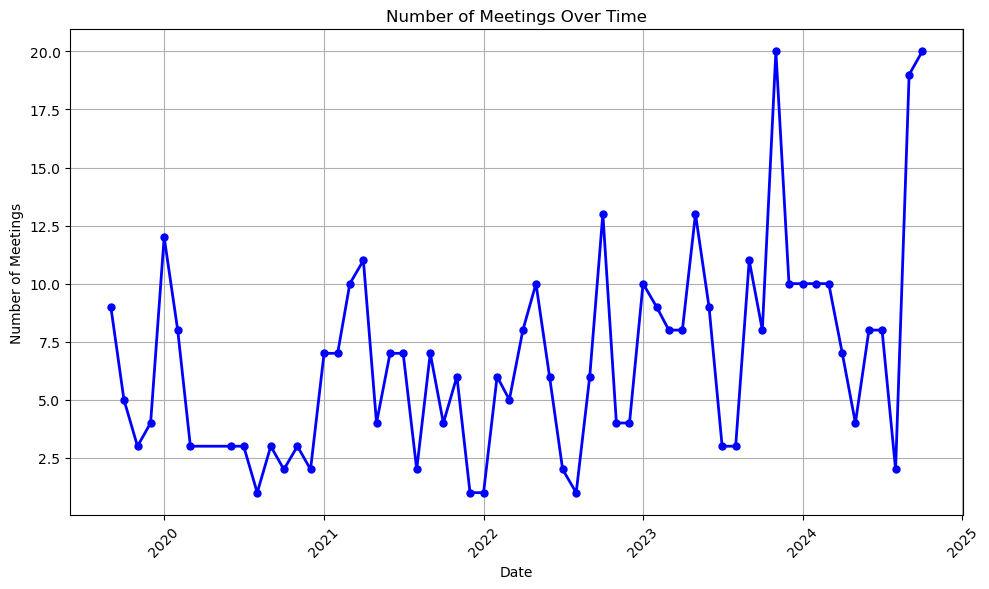

In [46]:
import os
import re
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from datetime import datetime

# Define the directory where your txt files are stored
directory = "C:/Users/Emilia/Documents/Uni Helsinki/Year Three/AMO Freelance/transparency register/results/china"  # Update this with your directory path

# Initialize a list to hold all meeting dates
meeting_dates = []

# Loop over all files in the specified directory
for filename in os.listdir(directory):
    if filename.endswith(".txt"):  # Process only .txt files
        file_path = os.path.join(directory, filename)
        
        # Open and read the content of the current txt file
        with open(file_path, "r") as file:
            data = file.read()
            
            # Define a regex pattern to extract the meeting dates from the text
            pattern = r"Date:\s*(\d{2}-\d{2}-\d{4})"
            
            # Find all meeting dates using the regex pattern
            meeting_dates.extend(re.findall(pattern, data))

# Convert the meeting dates into datetime objects for easier manipulation
meeting_dates = [datetime.strptime(date, "%d-%m-%Y") for date in meeting_dates]

# Create a list of month-year combinations
month_years = [date.strftime('%Y-%m') for date in meeting_dates]

# Count the number of meetings per month-year
meeting_counts = Counter(month_years)

# Convert the Counter to a pandas DataFrame for easy plotting
df = pd.DataFrame(meeting_counts.items(), columns=["Month-Year", "Meetings"])
df["Month-Year"] = pd.to_datetime(df["Month-Year"], format='%Y-%m')
df = df.sort_values("Month-Year")

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df["Month-Year"], df["Meetings"], marker='o', color='b', linestyle='-', linewidth=2, markersize=5)
plt.title("Number of Meetings Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Meetings")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()